# Parameter sensitivity study - loop 05 results overview


Loop 05 study was undertaken as an appendix already after about 5000 full games were simulated with parameters determined in previous loops.
Its aim is to optimize the decision making on whether given board state is more suitable to calculate with probabilistic method (mc) or the advanced one (adv).

So far, the threshold was fixed at 50 free fields in board state, after which the preferred method was switched from mc to adv. Games were simulated and calculation data saved, so that anytime certain board state appears again, it does not have to be calculated twice. This data accummulation should, on average, decrease the total game simulation time with every next game. But after about 5000 games I realized that this decrease rate is not as fast as I'd expect. 
One reason for that might be high percantage of total simulation time spent on advanced method calculations. Data accumulation might significantly speed up earlier phases of the game (when there are low number of game states possible and thus can repeat often) and be less effective when it comes to advanced calculations on board states that are already heavily branched (low chance of repeating).
From the time I realized this I started gathering calculation time data for both phases to back this theory and then try to find some more robust way of estimating the suitability of board state for adv calculation, to eliminate the outlier cases which bump up the average times.

500 board states samples were gathered, ranging from 30 < n_zeros <= 50.
For each of them, mc method was applied (average time taken from 3 runs) with the same parameters used as in global calculations (conf_level = 2.58, margin_estim = 1.00, margin_highest = 0.12). Yes, these are different than those used in study loop 03, but back then the final ones were not yet determined. Now it makes more sense to compare to what we are using in global game simulations.

The results described above are the input for loop 05 study.

## Fraction of calculation time spent on adv method

Figures below are presented as a proof that until now, in many cases, significant fraction of total game simulation time was spent in adv method calculation.
Adv method was meant to be used in late game stages when there's a lot of finishing moves requiring low-complexity but high precision calculation - then it is more efficient than monte-carlo. Ideally, on average it should last only a couple seconds and be no more than 10% whole game calculation time

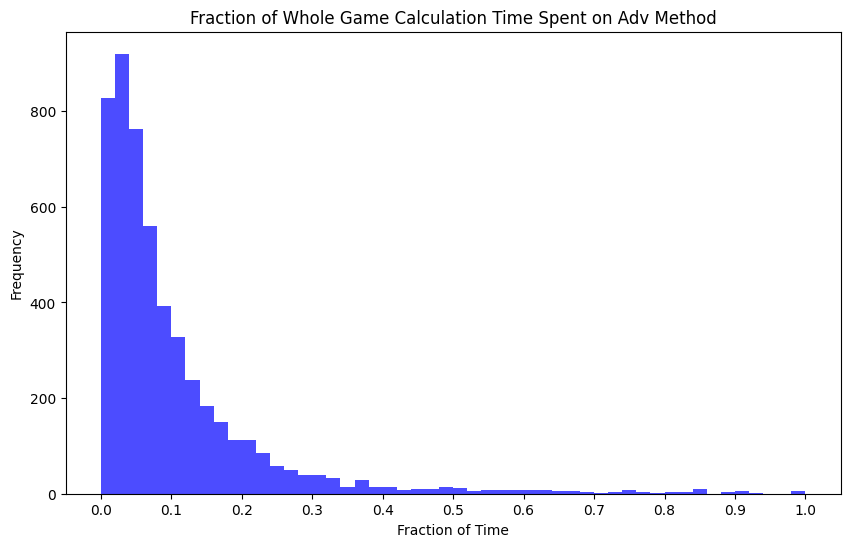

In [108]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

all_games_results_file_path = "all_games_results.csv"
df = pd.read_csv(all_games_results_file_path)

df['time_adv'] = df['time_game'] - df['time_at_switch']
df['adv_time_perc'] = df['time_adv'] / df['time_game']
df.dropna(subset=['adv_time_perc'], inplace=True)

# plot the fraction of time spent on adv method on histogram
plt.figure(figsize=(10, 6))
plt.hist(df['adv_time_perc'], bins=50, color='blue', alpha=0.7)
plt.title('Fraction of Whole Game Calculation Time Spent on Adv Method')
plt.xlabel('Fraction of Time')
plt.xticks(np.arange(0, 1.1, 0.1))
plt.ylabel('Frequency')
plt.show()

In [109]:
plt.figure(figsize=(10, 6))
plt.hist(df['time_adv'], bins=300, color='blue', alpha=0.7)
plt.title('Calculation Time Spent on Adv Method')
plt.xlabel('Time')
plt.xscale('log')
plt.xticks([1, 2, 5, 10, 20, 50, 100, 300], [1, 2, 5, 10, 20, 50, 100, 300])
plt.ylabel('Frequency')
plt.show()

# Loop 05 study

Now that we confirmed we have a problem with adv method being used too often, let's try to find the perfect switching point between the 2 methods.
Below we load the sensitivity study results file for loop 05. These contain mc / adv calculation times for each board state aswell as "cnf" parameters calculated specifically for this study, which will be explained later.

In [110]:
pd.set_option('display.width', 1000)
# pd.set_option('display.max_rows', 1700)
pd.set_option('display.max_columns', 20)
pd.set_option('max_colwidth', 2000)

param_sens_study_dir = "param_sens_study\\L05"
param_sens_study_file = "adv_time_data_with_mc.csv"
param_sens_study_path = os.path.join(param_sens_study_dir, param_sens_study_file)

df = pd.read_csv(param_sens_study_path)
print(df.sample(5))

                                                                                 board_state_100chars_code best_field  best_prob  time_adv   time_mc  cnf_5  cnf_4  cnf_3  cnf_2
1102  0070070000700070000000070070000007070700700077700777777577704444757270777775727707007577707007757070     [2, 1]   0.425272      2.76  1.830000    3.0    9.0   21.0   48.0
1696  7555557072777777707277770007777227000070777700000700071000000000700000007000000077777700007444470000     [4, 4]   0.597561      0.85  1.223333   14.0   25.0   41.0   62.0
1068  0000070070000000070000000000770777000073773700007307370000737737000077277777777727075555577707777777     [2, 4]   0.286914      2.17  1.506667   17.0   29.0   44.0   63.0
310   0111070700000700700070007000070777070070773700077707370070750737770075077737007570073707750007377075     [0, 0]   0.525134      1.80  0.543333    1.0    3.0   14.0   36.0
2132  0744447000077777700070007000007777010000333700700077770007770070070727070070772770777777770075555570     [4, 

"mc_adv_ratio" shall be our indicator on which method is more suitable. Values lower than one mean that mc method was faster than adv, and vice versa. We calculate that for all studied cases.

In [111]:
df['mc_adv_ratio'] = (df['time_mc'] / df['time_adv'])
print(df.sample(5))
print(df.describe())

                                                                                 board_state_100chars_code best_field  best_prob  time_adv   time_mc  cnf_5  cnf_4  cnf_3  cnf_2  mc_adv_ratio
2208  0070070007700700000000700000000700700000700700777777770775703337777577777722757200077775720007007577     [3, 8]   0.439318      0.50  1.163333    6.0   13.0   26.0   54.0      2.326667
3179  0073337073707777707307070007730070000777700010774707001007470070101747700007074700070077770700700722     [3, 4]   0.671875      0.19  0.613333    3.0    2.0    6.0   27.0      3.228070
1490  0007570000000757000000075700000007570000700757070700077770777777727074333772777477777770740007007074     [3, 8]   0.240158      1.39  1.396667    6.0   17.0   34.0   55.0      1.004796
1938  7700077227470000777747000075774700007570477000757077000075770070007570000700777707007777700710733370     [8, 2]   0.603727      0.75  1.033333   10.0   19.0   33.0   52.0      1.377778
2473  000000000000000000000000000700000070007

To get a feeling of how far we are from the ideal solution and how it looks like, we split all dataset into "MC-suited" and "ADV-suited" domains, based on mc_adv_ratio and calculate cumulative calculation time:
1. Assuming always optimal choice between adv/mc (perfect scenario - our end goal in this study)
2. Only using ADV method (what we did so far for all board states with n_zeros <= 50)
3. Only using MC method (safe middle ground, but taking no benefit from rapid ADV calculations in lategame scenarios)

In [112]:
mask_adv_suited = df.query('mc_adv_ratio >= 1')
adv_suited_time_adv = mask_adv_suited['time_adv'].sum()
adv_suited_time_mc  = mask_adv_suited['time_mc'].sum()

mask_mc_suited = df.query('mc_adv_ratio < 1')
mc_suited_time_adv = mask_mc_suited['time_adv'].sum()
mc_suited_time_mc  = mask_mc_suited['time_mc'].sum()

optimal_time = adv_suited_time_adv + mc_suited_time_mc
time_only_adv = adv_suited_time_adv + mc_suited_time_adv
time_only_mc = adv_suited_time_mc + mc_suited_time_mc

print(f'Optimal time: {optimal_time:.0f}s')
print(f'Only using ADV time: {time_only_adv:.0f}s')
print(f'Only using MC time: {time_only_mc:.0f}s')

Optimal time: 3276s
Only using ADV time: 14232s
Only using MC time: 4093s


Yet again it is confirmed that ADV method was being used too often. On the other hand, resigning fom it completely and always going with MC method is also far from perfection - that 800 seconds difference is additional 25% compared to optimal time, so it's worth fighting for. Specially considering its better accuracy than the probabilitic MC method.

To complete the overview, let's visualise it on a graph.

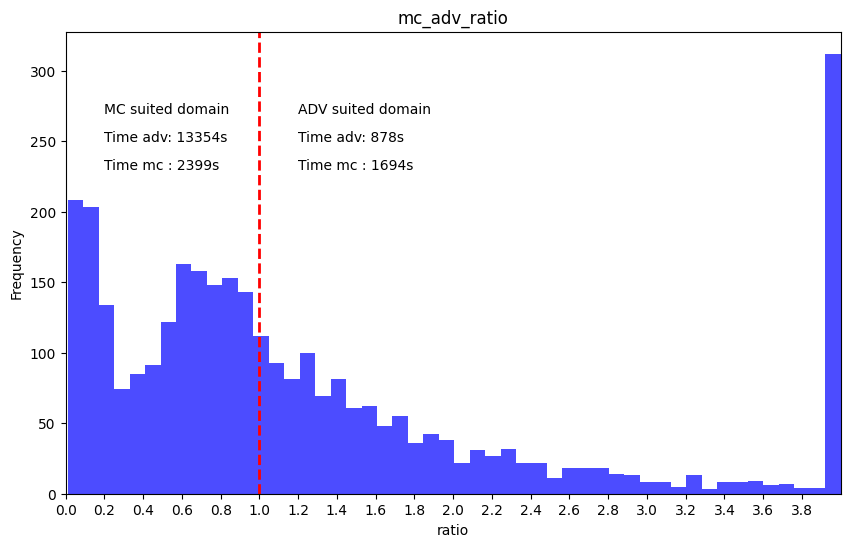

In [113]:
plt.figure(figsize=(10, 6))
plt.hist(np.clip(df['mc_adv_ratio'], 0, 4), bins=50, color='blue', alpha=0.7)
plt.title('mc_adv_ratio')
plt.xlabel('ratio')
plt.xlim(0, 4)
plt.xticks(np.arange(0, 4, 0.2))
plt.ylabel('Frequency')
plt.axvline(x=1, color='red', linestyle='--', linewidth=2)

plt.text(0.2, 270, f'MC suited domain')
plt.text(0.2, 250, f'Time adv: {mc_suited_time_adv:.0f}s')
plt.text(0.2, 230, f'Time mc : {mc_suited_time_mc:.0f}s')

plt.text(1.2, 270, f'ADV suited domain')
plt.text(1.2, 250, f'Time adv: {adv_suited_time_adv:.0f}s')
plt.text(1.2, 230, f'Time mc : {adv_suited_time_mc:.0f}s')

plt.show()

### Board state features

The most basic information we can extract from the board state is the count of certain symbols on the board. We were already using n_zeros before as a sole feature that influenced method choice, which turned to be insuficient. Let's now add all other symbols (from 1 to 5).

The "cnf" parameters, which were already loaded in the result file, were calculated as the total number of possible configurations in which the ship of given size can be placed on the board (see random_board_generator.create_configs function). From these values we will derive a "comb_total" parameter, which is a rough estimate of total possible combinations of ships left to be placed in given board state. In my understanding, board states with high values of comb_total should be less suitable for ADV calculation.

For each ship size, its cnf value is raised to the power of {number of ships of this size left to be placed on considered board}. Thus, 2-seg ships have usually the most influence when they are squared or even cubed.
Then, comb_total is a product of all cnf values adjusted and multiplied alltogether.

In [114]:
df['n_5'] = df['board_state_100chars_code'].apply(lambda x: x.count('5'))
df['n_4'] = df['board_state_100chars_code'].apply(lambda x: x.count('4'))
df['n_3'] = df['board_state_100chars_code'].apply(lambda x: x.count('3'))
df['n_2'] = df['board_state_100chars_code'].apply(lambda x: x.count('2'))
df['n_1'] = df['board_state_100chars_code'].apply(lambda x: x.count('1'))
df['n_0'] = df['board_state_100chars_code'].apply(lambda x: x.count('0'))

df['comb_5'] = df['cnf_5']**((5 - df['n_5']) / 5)
df['comb_4'] = df['cnf_4']**((4 - df['n_4']) / 4)
df['comb_3'] = df['cnf_3']**((6 - df['n_3']) / 3)
df['comb_2'] = df['cnf_2']**((6 - df['n_2']) / 2)

df['comb_total'] = (df['comb_5'] * df['comb_4'] * df['comb_3'] * df['comb_2'])
print(df.sample(10))

                                                                                 board_state_100chars_code best_field  best_prob  time_adv   time_mc  cnf_5  cnf_4  cnf_3  cnf_2  mc_adv_ratio  ...  n_4  n_3  n_2  n_1  n_0  comb_5  comb_4  comb_3    comb_2  comb_total
1638  7777700000722700000077770070007777777777227755555777777777770000700070000007770000000727000007072700     [7, 9]   0.424062      0.79  0.840000    5.0   14.0   33.0   58.0      1.063291  ...    0    0    6    0   44     1.0    14.0  1089.0       1.0     15246.0
357   0000700000000000000070000000000700000077777777777307555557730777777773707070007707777770000744447700     [8, 8]   0.269932     40.86  2.463333   14.0   24.0   40.0   63.0      0.060287  ...    4    3    0    0   49     1.0     1.0    40.0  250047.0  10001880.0
1335  7700007777570000733357000077775770077777570007333757000777777700074707000007477000000747070070074700     [8, 1]   0.213663      2.09  1.450000   15.0   23.0   38.0   58.0      0.693780  ...    

Let's see if any of these features corellates to the adv_mc_ratio:

In [115]:
df.corr(method='pearson', numeric_only=True).round(2)

,best_prob,time_adv,time_mc,cnf_5,cnf_4,cnf_3,cnf_2,mc_adv_ratio,n_5,n_4,n_3,n_2,n_1,n_0,comb_5,comb_4,comb_3,comb_2,comb_total
best_prob,1.00,-0.07,-0.45,-0.38,-0.43,-0.43,-0.42,-0.22,-0.38,-0.36,-0.06,0.22,0.66,0.06,0.23,0.14,0.00,-0.18,-0.01
time_adv,-0.07,1.00,0.43,0.17,0.19,0.21,0.27,-0.17,0.11,0.13,-0.12,-0.43,-0.07,0.33,-0.08,-0.07,0.05,0.64,0.86
time_mc,-0.45,0.43,1.00,0.42,0.44,0.41,0.39,0.02,0.28,0.23,-0.16,-0.42,-0.24,0.27,-0.17,-0.04,0.11,0.39,0.43
cnf_5,-0.38,0.17,0.42,1.00,0.96,0.86,0.74,-0.08,0.13,0.19,-0.10,-0.03,-0.24,0.42,0.02,0.09,0.22,0.21,0.12
cnf_4,-0.43,0.19,0.44,0.96,1.00,0.95,0.83,-0.10,0.11,0.20,-0.08,-0.05,-0.30,0.47,0.04,0.11,0.22,0.22,0.13
cnf_3,-0.43,0.21,0.41,0.86,0.95,1.00,0.93,-0.15,0.06,0.13,-0.01,-0.06,-0.36,0.55,0.07,0.16,0.19,0.23,0.13
cnf_2,-0.42,0.27,0.39,0.74,0.83,0.93,1.00,-0.24,0.06,0.07,-0.06,-0.08,-0.44,0.68,0.06,0.19,0.20,0.24,0.16
mc_adv_ratio,-0.22,-0.17,0.02,-0.08,-0.10,-0.15,-0.24,1.00,0.04,0.15,0.10,0.27,-0.06,-0.47,-0.04,-0.14,-0.06,-0.19,-0.12
n_5,-0.38,0.11,0.28,0.13,0.11,0.06,0.06,0.04,1.00,-0.07,-0.15,-0.23,-0.33,-0.13,-0.76,0.08,0.10,0.13,0.08
n_4,-0.36,0.13,0.23,0.19,0.20,0.13,0.07,0.15,-0.07,1.00,-0.38,-0.24,-0.20,-0.13,0.07,-0.82,0.18,0.17,0.09


Comb_total corellates very strongly with time_adv - makes sense, as we need to count every possible combination in that method. MC method on the other hand, is not so heavily corellated to total number of possibilites.
There's no direct corellation between mc_adv_ratio and comb_total though. It doesn't yet necessarily mean this metric won't have any use, just that it won't be as easy as I initially imagined...

So, which number counts are most heavily influening the mc_adv_ratio? It's the n_0 again, but this time we know this alone probably won't be enough. My guess is that n_2 plays a big role, it's also the second highest corellation in the table, so we shall try build our model based on these 2 features.

Let's plot the heatmap of mc_adv_ratio based on n_0 vs n_2 table. 

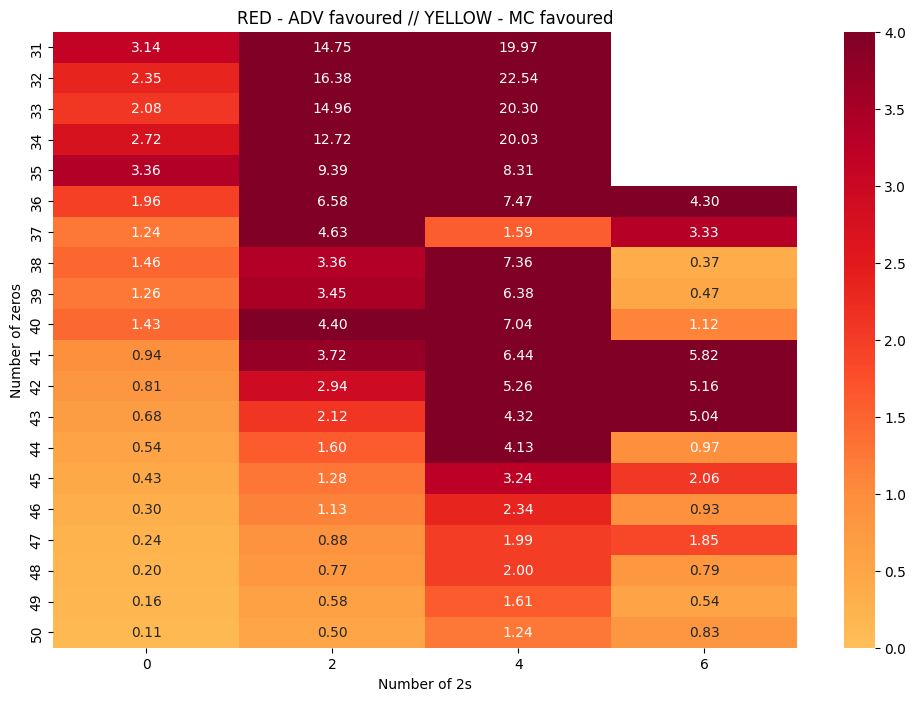

In [116]:
import seaborn as sns
from matplotlib.colors import ListedColormap, BoundaryNorm

# mc_adv_ratio as heatmap of n_0 vs n_2
# Create pivot table for heatmap
pivot_table = df.pivot_table(values='mc_adv_ratio', index='n_0', columns='n_2', aggfunc='mean')

# Create heatmap
plt.figure(figsize=(12, 8))

sns.heatmap(pivot_table, cmap='YlOrRd', annot=True, fmt='.2f', center = 1, vmin=0,vmax=4 )

plt.title('RED - ADV favoured // YELLOW - MC favoured')
plt.xlabel('Number of 2s')
plt.ylabel('Number of zeros')
plt.show()

n0 and n2 work pretty well together in separating the mc_adv_ratio values. Take a look at n0 = 48, depending on different n_2 values, the MC calculation time could be either 5x faster than ADV, or 2x slower. The general tendency is clear - the more n_2 already placed, the heavier ADV-favoured. Except, there seems to be a flip at n_2 = 6, but maybe it is just caused by low amount of samples and poor statistics.

In [117]:
print(df.query('n_2 == 6')[['n_0', 'n_2']].info())
print(df.query('n_2 == 6')[['n_0', 'n_2']].groupby('n_0', as_index=False).count().sort_values(by='n_0', ascending=True))

mc6 = df.query('n_2 == 6')['time_mc'].sum().round(1)
adv6 = df.query('n_2 == 6')['time_adv'].sum().round(1)
mc4 = df.query('n_2 == 4')['time_mc'].sum().round(1)
adv4 = df.query('n_2 == 4')['time_adv'].sum().round(1)

print(f'Time_mc sum when n_2 = 6: {mc6}s')
print(f'Time_adv sum when n_2 = 6: {adv6}s')

print(f'Time_mc sum when n_2 = 4: {mc4}s')
print(f'Time_adv sum when n_2 = 4: {adv4}s')

<class 'pandas.core.frame.DataFrame'>
Index: 57 entries, 645 to 3147
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   n_0     57 non-null     int64
 1   n_2     57 non-null     int64
dtypes: int64(2)
memory usage: 1.3 KB
None
    n_0  n_2
0    36    1
1    37    2
2    38    2
3    39    2
4    40    2
5    41    5
6    42    6
7    43    6
8    44    5
9    45    4
10   46    4
11   47    5
12   48    5
13   49    5
14   50    3
Time_mc sum when n_2 = 6: 28.4s
Time_adv sum when n_2 = 6: 26.7s
Time_mc sum when n_2 = 4: 653.0s
Time_adv sum when n_2 = 4: 393.2s


Definitely, 57 samples of n_2 = 6 distributed over 15 groups is not enough to draw conlusions from. The total time from these samples is also so low that we shall not care, they are just fine using both methods anyway.

## Machine learning model

With the established features, we can now try to build a model which would predict mc_adv_ratio based on them.

The goal is to have a model that I can implement by hand in game simulation script, without referring to external model file. It must be simple and explainable. The choice becomes obvious - decision tree.

Let's begin with regression tree trying to predict mc_adv_ratio value based on n_0, n_2 and comb_total.

[Text(0.5, 0.8333333333333334, 'n_0 <= 34.5\nsquared_error = 20.32\nsamples = 3203\nvalue = 2.159'),
 Text(0.25, 0.5, 'n_2 <= 3.0\nsquared_error = 251.055\nsamples = 71\nvalue = 16.791'),
 Text(0.375, 0.6666666666666667, 'True  '),
 Text(0.125, 0.16666666666666666, 'squared_error = 39.834\nsamples = 38\nvalue = 13.467'),
 Text(0.375, 0.16666666666666666, 'squared_error = 466.912\nsamples = 33\nvalue = 20.618'),
 Text(0.75, 0.5, 'n_0 <= 43.5\nsquared_error = 10.126\nsamples = 3132\nvalue = 1.827'),
 Text(0.625, 0.6666666666666667, '  False'),
 Text(0.625, 0.16666666666666666, 'squared_error = 20.677\nsamples = 983\nvalue = 3.391'),
 Text(0.875, 0.16666666666666666, 'squared_error = 3.668\nsamples = 2149\nvalue = 1.111')]

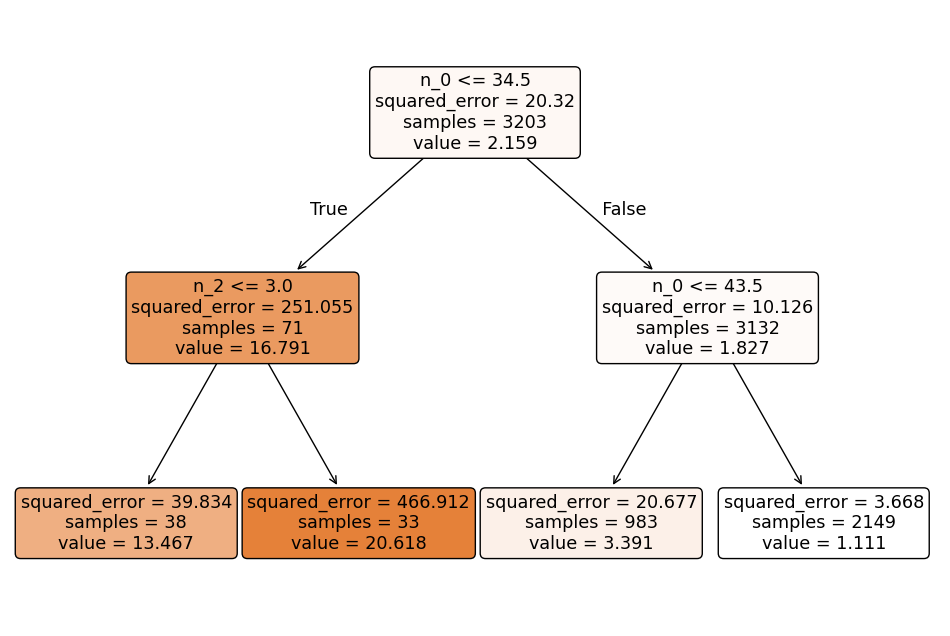

In [118]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor(max_depth=2, random_state=20)
X = df[['n_0', 'n_2']]
y = df['mc_adv_ratio']
dt.fit(X, y)

# Visialise dt
from sklearn.tree import plot_tree
plt.figure(figsize=(12, 8))
plot_tree(dt, feature_names=X.columns, filled=True, rounded=True)

This isn't very useful though, because we don't really care about error of estimating the exact mc_adv_ratio value. 

What is important for us is this being lower or higher than 1, so based on that we can decide which calculation method is faster. Therefore, let's transfrom it into binary classification problem.

In [119]:
df['target_binary'] = (df['mc_adv_ratio'] >= 1).astype(int)
X = df[['n_5', 'n_4', 'n_3', 'n_2', 'n_1', 'n_0', 'comb_total']]

y_binary = df['target_binary']
y_continuous = df['mc_adv_ratio']

But now, accuracy metrics are also not ideal for our case. Imagine there could be 99 board states classified correctly, which calculate 0.1s faster each, but 1 state misclassified which costs us additional 20 seconds. We can't really tell which model is best by just looking at accuracy metrics. 

We need to introduce a custom metrics suited for our case. That will be total accumulated calculation time when making method choices based on model predictions. Only this way we get a global view on how the model performs and we can compare it to the "ideal choices scenario".

In [120]:
from sklearn.metrics import make_scorer
import numpy as np

def accumulated_time(y_pred_binary, y_test_adv, y_test_mc):
    # If prediction is 1 (mc longer than adv), use adv time. If 0, reverse.
    mask = y_pred_binary.astype(bool)
    chosen_times = np.where(mask, y_test_adv.values, y_test_mc.values)
    return np.sum(chosen_times)


We will also employ cross validation to see how much dependent on the original data subset our models will be. Since we want to use custom metrics, this will require more manual definition of the CV method.

In [121]:
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import clone

def cross_val_custom_metric(source_df, model, X, y_binary, original_target, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=20)
    scores = []

    for train_idx, test_idx in skf.split(X, y_binary):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y_binary.iloc[train_idx], y_binary.iloc[test_idx]
        y_target_test = original_target.iloc[test_idx]

        y_test_adv = source_df['time_adv'].iloc[test_idx]
        y_test_mc = source_df['time_mc'].iloc[test_idx]

        print(y_test_adv.mean(), y_test_mc.mean())

        clf = clone(model)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        score = accumulated_time(y_pred, y_test_adv, y_test_mc)
        scores.append(score)

    return scores

Before we test some models, we prepare some more reference information to compare against

In [122]:
# method_choice_previous 1 if n_0 <=50 else 0
df['method_choice_previous'] = (df['n_0'] <= 50).astype(int)
df['time_choice_previous'] = df['time_adv'] * df['method_choice_previous'] + df['time_mc'] * (1 - df['method_choice_previous'])


df['time_shortest'] = np.minimum(df['time_adv'], df['time_mc'])

In [123]:
from sklearn.tree import plot_tree

def make_model(df, X, y_binary, y_continuous, depth):
    model = DecisionTreeClassifier(max_depth=depth, random_state=88)
    model.fit(X, y_binary)
    df['method_choice'] = model.predict(X)
    df['time_choice'] = df['time_adv'] * df['method_choice'] + df['time_mc'] * (1 - df['method_choice'])

    # Run cross-validation with custom metric
    scores = cross_val_custom_metric(df, model, X, y_binary, y_continuous, n_splits=5)
    print("Accumulated calculation time per fold:", scores)

    print(f"Time sum optimized: {df['time_choice'].sum().round(1)}")
    print(f"Time sum shortest: {df['time_shortest'].sum().round(1)}")
    print(f"Time sum previous: {df['time_choice_previous'].sum().round(1)} (n_0 <= 50 calculated with ADV)")
    
    return model

def visualize_dt(model, X):
     # Visialise dt
    plt.figure(figsize=(8, 4))
    plot_tree(model, feature_names=X.columns, filled=True, rounded=True)

4.259110764430577 1.249365574622985
4.377347893915757 1.3032085283411339
4.769641185647426 1.2829901196047844
4.94415625 1.2983072916666667
3.865734375 1.2552968749999998
Accumulated calculation time per fold: [np.float64(681.16), np.float64(715.4599999999999), np.float64(707.83), np.float64(711.2133333333334), np.float64(679.7266666666667)]
Time sum optimized: 3494.8
Time sum shortest: 3276.3
Time sum previous: 14231.6 (n_0 <= 50 calculated with ADV)


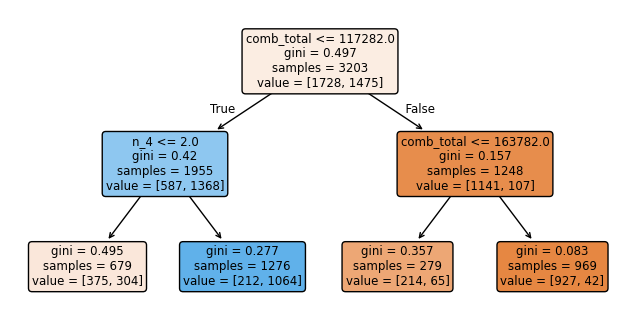

In [124]:
model = make_model(df, X, y_binary, y_continuous, depth = 2)
visualize_dt(model, X)

The model looks really well, though not exactly as I expected. Happy to see comb_total making glorious comeback, so it does make some sense afterall. Really surprised to see n_4 here, on the other hand. 

Time sum of 3494s is really good results compared o 3276 with ideal choices.
It's also generalising quite well, with results of different train-test splits ranging from 681s to 715s. 


Next, let's experiment with different sets of features to account. Behind the scenes I also checked different depths in each model, but usually depth=2 works best. Anyways, I don't want to overcomplicate it and go deeper than 3 
levels.

1. Let's see how well we could do by just predicting based on n_0 (adjust the boundary previously set to 50)

In [125]:
X = df[['n_0']]
model = make_model(df, X, y_binary, y_continuous, depth = 2)

4.259110764430577 1.249365574622985
4.377347893915757 1.3032085283411339
4.769641185647426 1.2829901196047844
4.94415625 1.2983072916666667
3.865734375 1.2552968749999998
Accumulated calculation time per fold: [np.float64(896.4566666666667), np.float64(935.7166666666666), np.float64(918.1666666666667), np.float64(815.75), np.float64(855.4799999999999)]
Time sum optimized: 4421.6
Time sum shortest: 3276.3
Time sum previous: 14231.6 (n_0 <= 50 calculated with ADV)


Not so good. In fact, it's worse than only using MC method (total time = 4093s, as calculated before). We really need those additional features.

2. Then, let's use the original features but without comb_total

4.259110764430577 1.249365574622985
4.377347893915757 1.3032085283411339
4.769641185647426 1.2829901196047844
4.94415625 1.2983072916666667
3.865734375 1.2552968749999998
Accumulated calculation time per fold: [np.float64(691.8899999999999), np.float64(707.7166666666667), np.float64(699.3266666666666), np.float64(722.3433333333334), np.float64(712.9833333333333)]
Time sum optimized: 3534.3
Time sum shortest: 3276.3
Time sum previous: 14231.6 (n_0 <= 50 calculated with ADV)


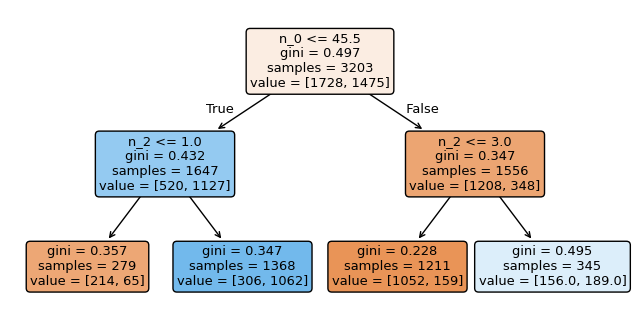

In [126]:
X = df[['n_5', 'n_4', 'n_3', 'n_2', 'n_1', 'n_0']]
model = make_model(df, X, y_binary, y_continuous, depth = 2)
visualize_dt(model, X)

This model yields around 40s more total time than the one including comb_total, but is a bit simpler. With that I wouldn't have to calculate the comb_total parameter at all, which for all cases for this study took around 25seconds total. Still better by 15secs one might say, but I think it's just going to make the main game simulation code more complex and less understandable for very little benefit. 

Farewell then, comb_total. I'll just stay with n_0 and n_2 criterions, as they are super simple and do the job well enough. Below is the conditionals implementation I'm going to apply in main game code.

In [127]:
def choose_method(n_zeros, n_2):
    if n_zeros > 50:
        method_choice = "mc"
    else:
        if n_zeros >= 46:
            if n_2 >= 4:
                method_choice = "adv"
            else:
                method_choice = "mc"
        else:
            if n_2 == 0:
                method_choice = "mc"
            else:
                method_choice = "adv"
    return method_choice